# 2a Reason: Continuous Features

Imports

In [1]:
from pathlib import Path
from functools import partial
import numpy as np
import pandas as pd

from sklearn.model_selection import RepeatedStratifiedKFold, RepeatedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import KBinsDiscretizer

import joblib
from scipy.stats import chi2
from julearn import run_cross_validation

import matplotlib.pyplot as plt
import matplotlib as mpl
from sciplotlib import style
import seaborn as sns

from leakconfound.plotting import mm_to_inch
from leakconfound.analyses.utils import save_paper_val
from leakconfound.plotting.settings import red, blue, green, purple


Prepare Paths

In [2]:
base_dir = '../../'
base_save_paper = "./paper_val/"
increase_features_save_paper = "./paper_val/increase_features/"
Path(increase_features_save_paper).mkdir(parents=True, exist_ok=True)

Prepare Plotting

In [3]:
mpl.style.use(style.get_style('nature-reviews'))
mpl.rc('xtick', labelsize=11)
mpl.rc('ytick', labelsize=11)
mpl.rc('axes', labelsize=12, titlesize=12)
mpl.rc('figure', dpi=300)
mpl.rc('figure.subplot', wspace=mm_to_inch(4), hspace=mm_to_inch(10))
mpl.rc('lines', linewidth=1)
np.random.seed(891236740)

# using two Normal Distributions


Functions to Sample from Distributions

In [4]:
def normal_with_bump(loc_main, scale_main,
                     loc_minor, scale_minor,
                     size_main, size_minor):
    """Function to fuze two normal distributions.
    E.g. to create normal dist + another around extreme values
    """

    arr_main = np.random.normal(
        loc_main, scale_main, size=size_main)
    arr_minor = np.random.normal(
        loc_minor, scale_minor, size_minor
    )
    arr_both = np.concatenate([arr_main, arr_minor])
    np.random.shuffle(arr_both)
    return arr_both


skewed_sampler = partial(chi2.rvs, df=3)

## Features with Opposing Small Extreme Distributions
Prepare Data

In [5]:
target = np.array([[0, 1]*500]).flatten()

feat_1 = np.zeros(len(target))
feat_1[target == 0] = normal_with_bump(0, 1, -4, .5, 450, 50)
feat_1[target == 1] = normal_with_bump(0, 1, 4, .5, 450, 50)


df = pd.DataFrame(dict(
    feat_1=feat_1,
    conf=target, target=target))

Run Analysis

In [6]:
res_no_rem, est_no_rem = run_cross_validation(
    X=['feat_1'], y='target', data=df,
    model=DecisionTreeClassifier(), preprocess_X=['zscore'],
    cv=RepeatedStratifiedKFold(),
    scoring='roc_auc', return_estimator='final'

)
scores_no_rem = res_no_rem.groupby("repeat").mean().test_score

res_rem, est_rem = run_cross_validation(
    X=['feat_1'], y='target', data=df, confounds=['conf'],
    model=DecisionTreeClassifier(), preprocess_X=['zscore', 'remove_confound'],
    cv=RepeatedStratifiedKFold(),
    scoring='roc_auc', return_estimator='final'

)

CV Scores

In [7]:
scores_rem = res_rem.groupby("repeat").mean().test_score

print(f'Scores no removal: M = '
      f'{scores_no_rem.mean():.4f}, sd = {scores_no_rem.std():.4f}')
save_paper_val(base_save_paper, "reasons_continuous_feat", "raw",
               "mean_opposing_extreme.txt", round(scores_no_rem.mean(), 2))

save_paper_val(base_save_paper, "reasons_continuous_feat", "raw",
               "std_opposing_extreme.txt", round(scores_no_rem.std(), 2))
print(f'Scores with removal: M = '
      f'{scores_rem.mean():.4f}, sd = {scores_rem.std():.4f}')

save_paper_val(base_save_paper, "reasons_continuous_feat", "removed",
               "mean_opposing_extreme.txt", round(scores_rem.mean(), 2))

save_paper_val(base_save_paper, "reasons_continuous_feat", "removed",
               "std_opposing_extreme.txt", round(scores_rem.std(), 2))


Scores no removal: M = 0.5106, sd = 0.0107
Scores with removal: M = 0.5834, sd = 0.0130


## Score on Additional Test Sample & Plotting

In [8]:
target = np.array([[0, 1]*500]).flatten()

feat_1 = np.zeros(len(target))
feat_1[target == 0] = normal_with_bump(0, 1, -4, .5, 450, 50)
feat_1[target == 1] = normal_with_bump(0, 1, 4, .5, 450, 50)


df_test = pd.DataFrame(dict(
    feat_1=feat_1,
    conf=target, target=target))

In [9]:
pred_rm = est_rem.predict(df_test[['feat_1', 'conf']])
pred_no_rm = est_no_rem.predict(df_test[['feat_1']])

score_rm = roc_auc_score(df_test['target'], pred_rm)
score_no_rm = roc_auc_score(df_test['target'], pred_no_rm)
print('New test set performance (same sampling procedure): ')
print(f'{score_rm = } \n {score_no_rm = }')


New test set performance (same sampling procedure): 
score_rm = 0.585 
 score_no_rm = 0.534


Text(0.05, 0.9, 'AUCROC = 0.58')

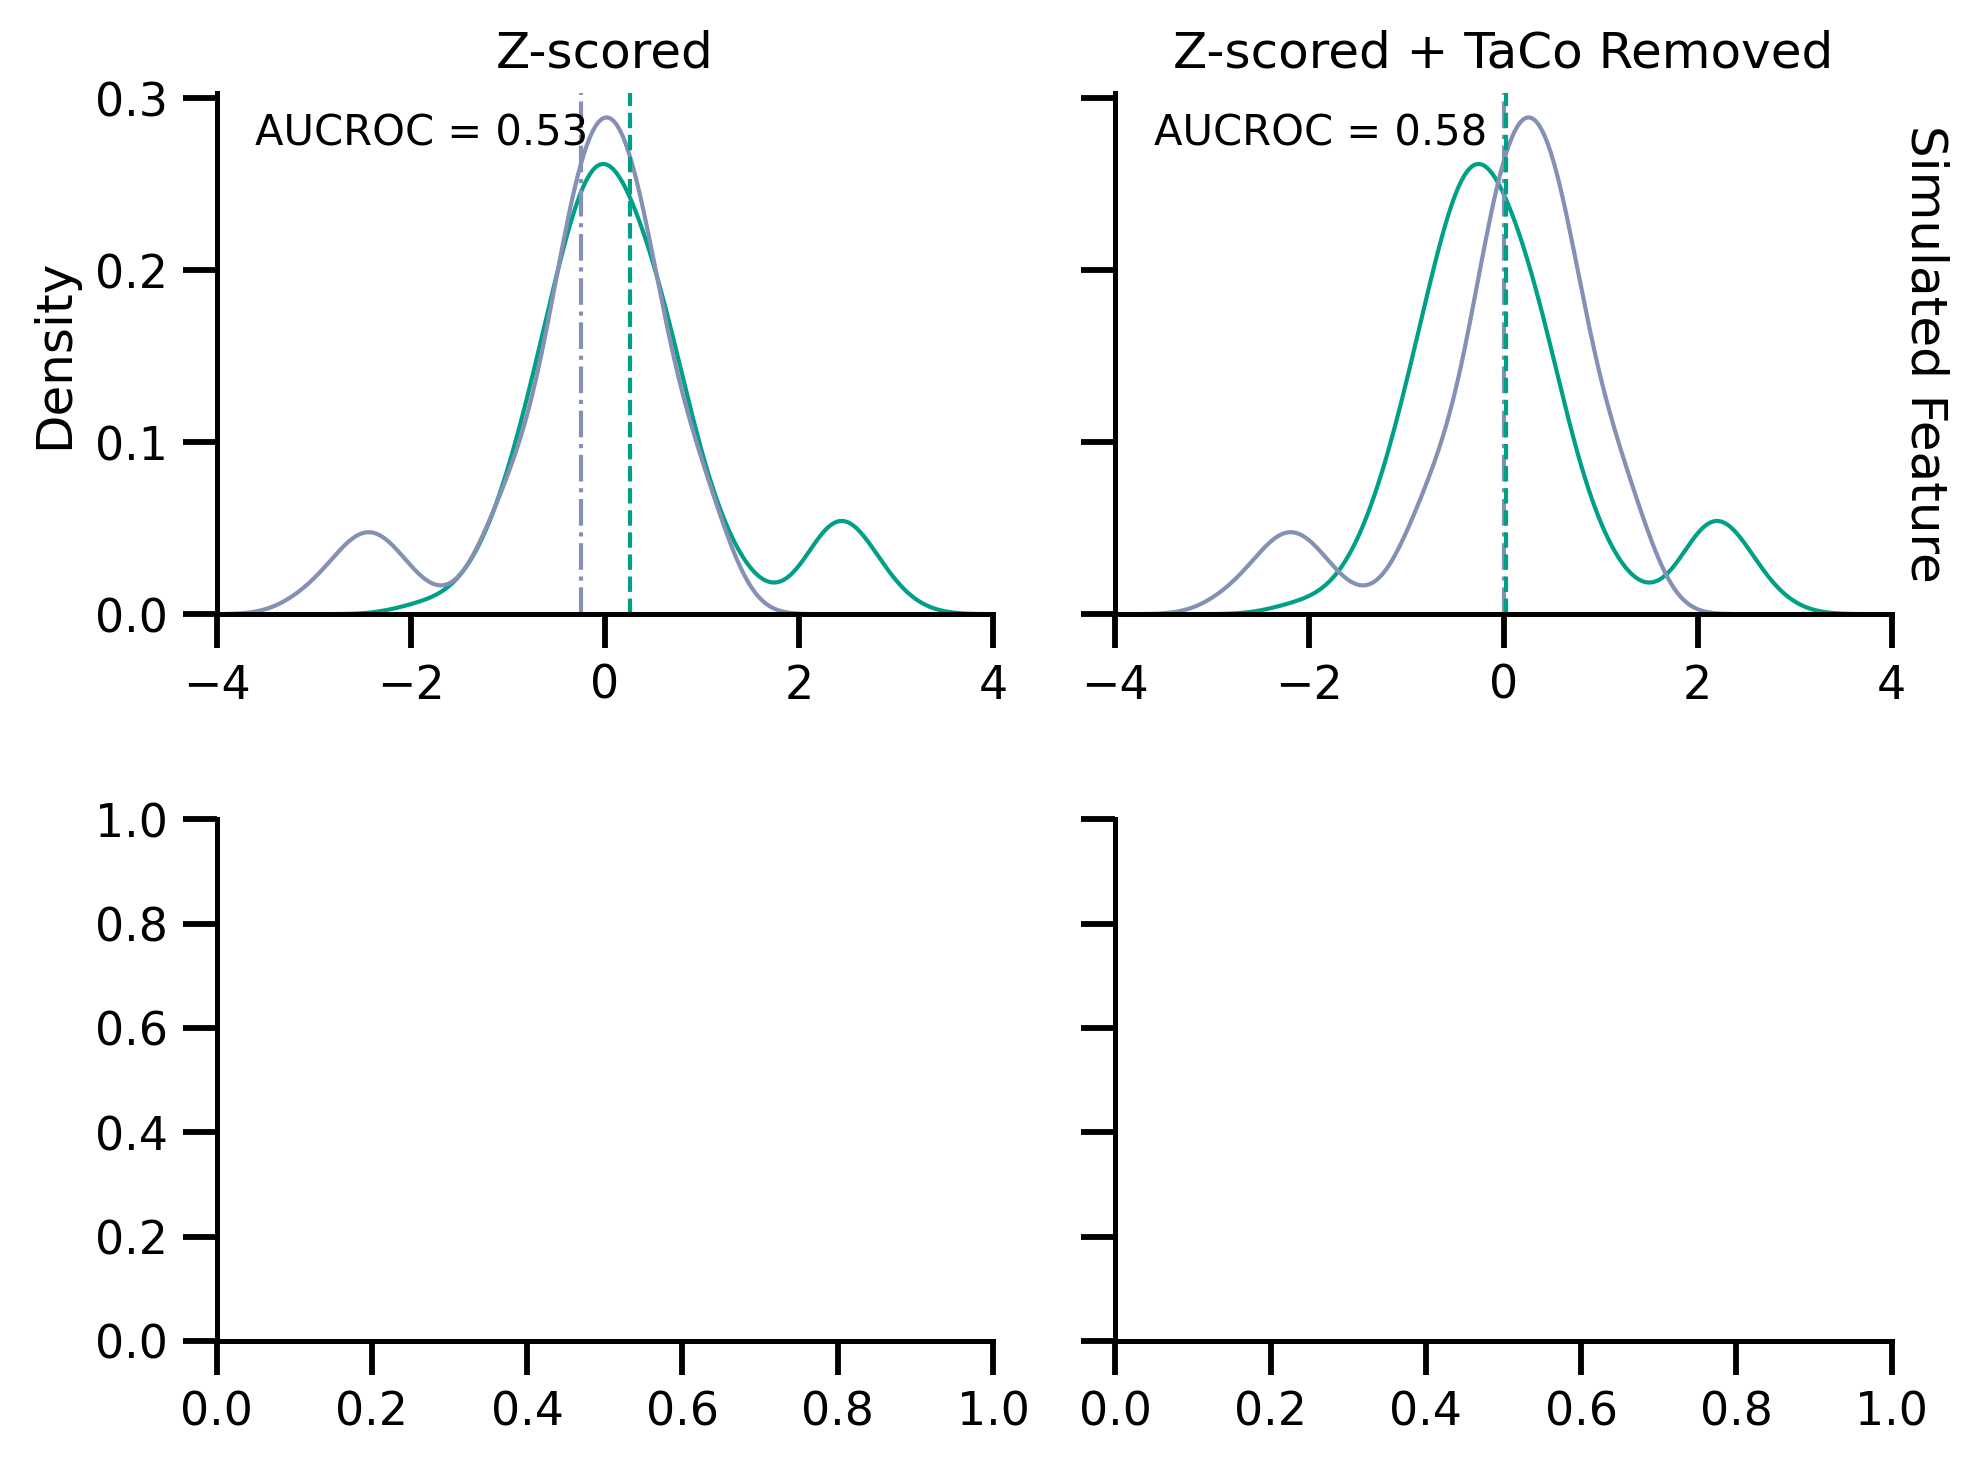

In [10]:
X_rm, _ = est_rem.preprocess(
    df_test[['feat_1', 'conf']], df_test.target)

X_no_rm, _ = est_no_rem.preprocess(
    df_test[['feat_1']], df_test.target)


fig, axes = plt.subplots(2, 2, figsize=[mm_to_inch(183),
                                        mm_to_inch(140)],
                         sharey="row")

g0 = sns.kdeplot(x=X_no_rm.feat_1, hue=df_test.target, ax=axes[0, 0],
                 palette=sns.color_palette([purple, green])
                 )
g0.set_xlim(-4, 4)

g = sns.kdeplot(x=X_rm.feat_1, hue=df_test.target, ax=axes[0, 1],
                palette=sns.color_palette([purple, green])
                )
g.set_xlim(-4, 4)


axes[0, 0].axvline(X_no_rm.feat_1[df_test.target == 0].values.mean(),
                   color=purple, ls="-.")
axes[0, 0].axvline(X_no_rm.feat_1[df_test.target == 1].values.mean(),
                   color=green, ls="--")

axes[0, 1].axvline(X_rm.feat_1[df_test.target == 0].values.mean(),
                   color=purple, ls="-.")
axes[0, 1].axvline(X_rm.feat_1[df_test.target == 1].values.mean(),
                   color=green, ls="--")

ax_twin = axes[0, 1].twinx()
ax_twin.set_ylabel('Simulated Feature', rotation=270, labelpad=8,
                   horizontalalignment='center', verticalalignment='center')
ax_twin.set_yticks([])
ax_twin.set_yticklabels("")

for ax in axes.flatten():
    ax.set_xlabel("")

axes[0, 0].set_title('Z-scored')
axes[0, 1].set_title('Z-scored + TaCo Removed')

axes[0, 0].get_legend().set_visible(False)
axes[0, 1].get_legend().set_visible(False)

axes[0, 0].text(.05, .9, f'AUCROC = {score_no_rm:.2}',
                transform=axes[0, 0].transAxes
                )
axes[0, 1].text(.05, 0.9, f'AUCROC = {score_rm:.2}',
                transform=axes[0, 1].transAxes
                )


In [11]:
def plot_bin(row, ax):
    x_min = row.name.left
    x_max = row.name.right
    chnaging_point = 1 - row.values[0]
    ax.axvspan(x_min, x_max, 0, chnaging_point,
               facecolor=purple, alpha=0.2, linewidth=None, ls='')
    ax.axvspan(x_min, x_max, chnaging_point, 1,
               facecolor=green, alpha=0.2, linewidth=None, ls='')


bin_number = 40
x_background_rm = np.arange(-4, 4, .005)
x_background_no_rm = np.arange(-4, 4, .005)


pred_all_val_no_rm = est_no_rem.named_steps.decisiontreeclassifier.predict(
    pd.DataFrame(dict(feat_1=x_background_no_rm)))

(pd.DataFrame(dict(pred=pred_all_val_no_rm, x=x_background_no_rm))
    .assign(bins=lambda df: pd.qcut(df.x, bin_number))
    .pipe(lambda df: pd.DataFrame(df.groupby('bins').pred.mean()))
    .apply(plot_bin, axis=1, ax=axes[0, 0])
 )


pred_all_val_rm = est_rem.named_steps.decisiontreeclassifier.predict(
    pd.DataFrame(dict(feat_1=x_background_rm)))

(pd.DataFrame(dict(pred=pred_all_val_rm, x=x_background_rm))
    .assign(bins=lambda df: pd.qcut(df.x, bin_number))
    .pipe(lambda df: pd.DataFrame(df.groupby('bins').pred.mean()))
    .apply(plot_bin, axis=1, ax=axes[0, 1])
 )

bins
(-4.001, -3.8]       None
(-3.8, -3.6]         None
(-3.6, -3.4]         None
(-3.4, -3.201]       None
(-3.201, -3.001]     None
(-3.001, -2.801]     None
(-2.801, -2.601]     None
(-2.601, -2.401]     None
(-2.401, -2.201]     None
(-2.201, -2.001]     None
(-2.001, -1.801]     None
(-1.801, -1.602]     None
(-1.602, -1.402]     None
(-1.402, -1.202]     None
(-1.202, -1.002]     None
(-1.002, -0.802]     None
(-0.802, -0.602]     None
(-0.602, -0.402]     None
(-0.402, -0.202]     None
(-0.202, -0.0025]    None
(-0.0025, 0.197]     None
(0.197, 0.397]       None
(0.397, 0.597]       None
(0.597, 0.797]       None
(0.797, 0.997]       None
(0.997, 1.197]       None
(1.197, 1.397]       None
(1.397, 1.596]       None
(1.596, 1.796]       None
(1.796, 1.996]       None
(1.996, 2.196]       None
(2.196, 2.396]       None
(2.396, 2.596]       None
(2.596, 2.796]       None
(2.796, 2.996]       None
(2.996, 3.195]       None
(3.195, 3.395]       None
(3.395, 3.595]       None
(3.595,

## Score on Additional Test Sample Without Extreme Distributions
Testing performance on addition test set only using a normal dist
This shows whether increase in performance is due to leackage or only better
pred of extreme values

In [12]:
target = np.array([[0, 1]*500]).flatten()

feat_1 = np.zeros(len(target))
feat_1[target == 0] = np.random.normal(size=500)
feat_1[target == 1] = np.random.normal(size=500)


df_test = pd.DataFrame(dict(
    feat_1=feat_1,
    conf=target, target=target))

pred_rm = est_rem.predict(df_test[['feat_1', 'conf']])
pred_no_rm = est_no_rem.predict(df_test[['feat_1']])

score_rm = roc_auc_score(df_test['target'], pred_rm)
score_no_rm = roc_auc_score(df_test['target'], pred_no_rm)
print('New test set performance (sampling only normal dist): ')
print(f'{score_rm = } \n {score_no_rm = }')


save_paper_val(base_save_paper, "reasons_continuous_feat", "raw",
               "mean_opposing_extreme_extra_test.txt", score_no_rm.mean())

save_paper_val(base_save_paper, "reasons_continuous_feat", "removed",
               "mean_opposing_extreme_extra_test.txt", score_rm.mean())


New test set performance (sampling only normal dist): 
score_rm = 0.5650000000000001 
 score_no_rm = 0.484


### Real World Example
Now we can look at an example with real data:
For this we will look at the real_estate dataset

In [13]:
# read in the models and the input data
case_rm = 'real_estate___decisiontree___True___716845___house_price_of_unit_area'
case_none = 'real_estate___decisiontree___False___716845___house_price_of_unit_area'

decisiontree_rm = joblib.load(
    f'{base_dir}/results/basic_TaCo/uci_datasets/models/{case_rm}.joblib'
)['decisiontreeregressor']

decisiontree_none = joblib.load(
    f'{base_dir}/results/basic_TaCo/uci_datasets/models/{case_none}.joblib'
)['decisiontreeregressor']

df = pd.read_csv(f'{base_dir}data/uci_datasets/real_estate.csv')

X = [col
     for col in df.columns.to_list()
     if col.endswith('categorical') or col.endswith('continuous')
     ]

confounds = ['house_price_of_unit_area__:type:__confound']
y = 'house_price_of_unit_area__regression_target'
df[confounds[0]] = df[y]  # make it TaCo


First, let us have a look at which features were important
in the original prediction task with and without TaCo removal

In [14]:
print("importance with removal")
print(decisiontree_rm.feature_importances_)
print('most important variables are 1, 4:',
      df.iloc[:, [1, 4]].columns)

print()
print("importance without removal")
print(decisiontree_none.feature_importances_)

importance with removal
[0.1055301  0.34810974 0.07908374 0.07494882 0.3923276 ]
most important variables are 1, 4: Index(['distance_to_the_nearest_MRT_station__continuous', 'longitude__continuous'], dtype='object')

importance without removal
[0.19743099 0.61044498 0.02933386 0.09701904 0.06577114]


Now we retrain and score a decisiontree using only these features
on a binarized TaCo for interpretation purposes

In [15]:
discretizer = KBinsDiscretizer(
    n_bins=2, strategy='quantile', encode='ordinal').fit(df[[y]])

y_ = 'House Price Quantiles'
df[y_] = discretizer.transform(df[[y]]).reshape(-1)


score_no_rm, model_bin_no_rm = run_cross_validation(
    X=['longitude__continuous'],
    preprocess_X=['zscore'],
    y=y_, data=df, model=DecisionTreeClassifier(),
    cv=RepeatedStratifiedKFold(),
    scoring='roc_auc',
    return_estimator='final'
)

pred_no_rm = model_bin_no_rm.predict(df[['longitude__continuous']])

score_rm, model_bin_rm = run_cross_validation(
    X=['longitude__continuous'],
    preprocess_X=['zscore', 'remove_confound'],
    confounds=[y_], y=y_,
    data=df, model=DecisionTreeClassifier(),
    cv=RepeatedStratifiedKFold(),
    scoring='roc_auc',
    return_estimator='final'

)

m_rm = score_rm.groupby("repeat").mean().test_score
m_no_rm = score_no_rm.groupby("repeat").mean().test_score

print('Scores DT pred binarized House Prize given longitude ')
print(f'Scores no removal: M = '
      f'{m_no_rm.mean():.4f}, sd = {m_no_rm.std():.4f}')
print(f'Scores with removal: M = '
      f'{m_rm.mean():.4f}, sd = {m_rm.std():.4f}')

save_paper_val(base_save_paper, "reasons_continuous_feat", "raw",
               "mean_dt_binarized_house.txt", round(m_no_rm.mean(), 2))

save_paper_val(base_save_paper, "reasons_continuous_feat", "raw",
               "std_dt_binarized_house.txt", round(m_no_rm.std(), 2))

save_paper_val(base_save_paper, "reasons_continuous_feat", "removed",
               "mean_dt_binarized_house.txt", round(m_rm.mean(), 2))

save_paper_val(base_save_paper, "reasons_continuous_feat", "removed",
               "std_dt_binarized_house.txt", round(m_rm.std(), 2))

Scores DT pred binarized House Prize given longitude 
Scores no removal: M = 0.8324, sd = 0.0100
Scores with removal: M = 0.9080, sd = 0.0135


In [16]:
pred_rm = model_bin_rm.predict(df[['longitude__continuous', y_]])

X_rm, _ = model_bin_rm.preprocess(
    df[['longitude__continuous', y_]], df[y_])

X_no_rm, _ = model_bin_no_rm.preprocess(
    df[['longitude__continuous']], df[y_])


g0 = sns.kdeplot(x=X_no_rm['longitude__continuous'], hue=df[y_], ax=axes[1, 0],
                 palette=sns.color_palette([purple, green])

                 )
axes[1, 0].axvline(X_no_rm[df[y_] == 0].values.mean(),
                   color=purple, ls='-.')
axes[1, 0].axvline(X_no_rm[df[y_] == 1].values.mean(),
                   color=green, ls='--')

axes[1, 1].axvline(X_rm[df[y_] == 0].values.mean(),
                   color=purple, ls='-.')
axes[1, 1].axvline(X_rm[df[y_] == 1].values.mean(),
                   color=green, ls='--')

g0.set_xlim(-4, 4)

g = sns.kdeplot(x=X_rm['longitude__continuous'], hue=df[y_], ax=axes[1, 1],
                palette=sns.color_palette([purple, green])
                )
g.set_xlim(-4, 4)


ax_twin = axes[1, 1].twinx()
ax_twin.set_ylabel('Logitude', rotation=270, labelpad=8,
                   horizontalalignment='center', verticalalignment='center')
ax_twin.set_yticks([])
ax_twin.set_yticklabels("")


axes[1, 0].set_title('')
axes[1, 1].set_title('')

axes[1, 0].get_legend().set_visible(False)
axes[1, 1].get_legend().set_visible(False)
axes[1, 0].text(.05, 0.9,
                f'AUCROC = {score_no_rm.test_score.mean() :.2}',
                transform=axes[1, 0].transAxes

                )
axes[1, 1].text(.05, 0.9,
                f'AUCROC = {score_rm.test_score.mean():.2}',
                transform=axes[1, 1].transAxes
                )

for ax in axes[1]:
    ax.set_xlabel("")

In [17]:
bin_number = 40
x_background = np.arange(-4, 4, .005)


pred_all_val_no_rm = model_bin_no_rm.named_steps.decisiontreeclassifier.predict(
    pd.DataFrame(dict(longitude__continuous=x_background)))

(pd.DataFrame(dict(pred=pred_all_val_no_rm, x=x_background))
    .assign(bins=lambda df: pd.qcut(df.x, bin_number))
    .pipe(lambda df: pd.DataFrame(df.groupby('bins').pred.mean()))
    .apply(plot_bin, axis=1, ax=axes[1, 0])
 )


pred_all_val_rm = model_bin_rm.named_steps.decisiontreeclassifier.predict(
    pd.DataFrame(dict(longitude__continuous=x_background)))

(pd.DataFrame(dict(pred=pred_all_val_rm, x=x_background))
    .assign(bins=lambda df: pd.qcut(df.x, bin_number))
    .pipe(lambda df: pd.DataFrame(df.groupby('bins').pred.mean()))
    .apply(plot_bin, axis=1, ax=axes[1, 1])
 )

bins
(-4.001, -3.8]       None
(-3.8, -3.6]         None
(-3.6, -3.4]         None
(-3.4, -3.201]       None
(-3.201, -3.001]     None
(-3.001, -2.801]     None
(-2.801, -2.601]     None
(-2.601, -2.401]     None
(-2.401, -2.201]     None
(-2.201, -2.001]     None
(-2.001, -1.801]     None
(-1.801, -1.602]     None
(-1.602, -1.402]     None
(-1.402, -1.202]     None
(-1.202, -1.002]     None
(-1.002, -0.802]     None
(-0.802, -0.602]     None
(-0.602, -0.402]     None
(-0.402, -0.202]     None
(-0.202, -0.0025]    None
(-0.0025, 0.197]     None
(0.197, 0.397]       None
(0.397, 0.597]       None
(0.597, 0.797]       None
(0.797, 0.997]       None
(0.997, 1.197]       None
(1.197, 1.397]       None
(1.397, 1.596]       None
(1.596, 1.796]       None
(1.796, 1.996]       None
(1.996, 2.196]       None
(2.196, 2.396]       None
(2.396, 2.596]       None
(2.596, 2.796]       None
(2.796, 2.996]       None
(2.996, 3.195]       None
(3.195, 3.395]       None
(3.395, 3.595]       None
(3.595,

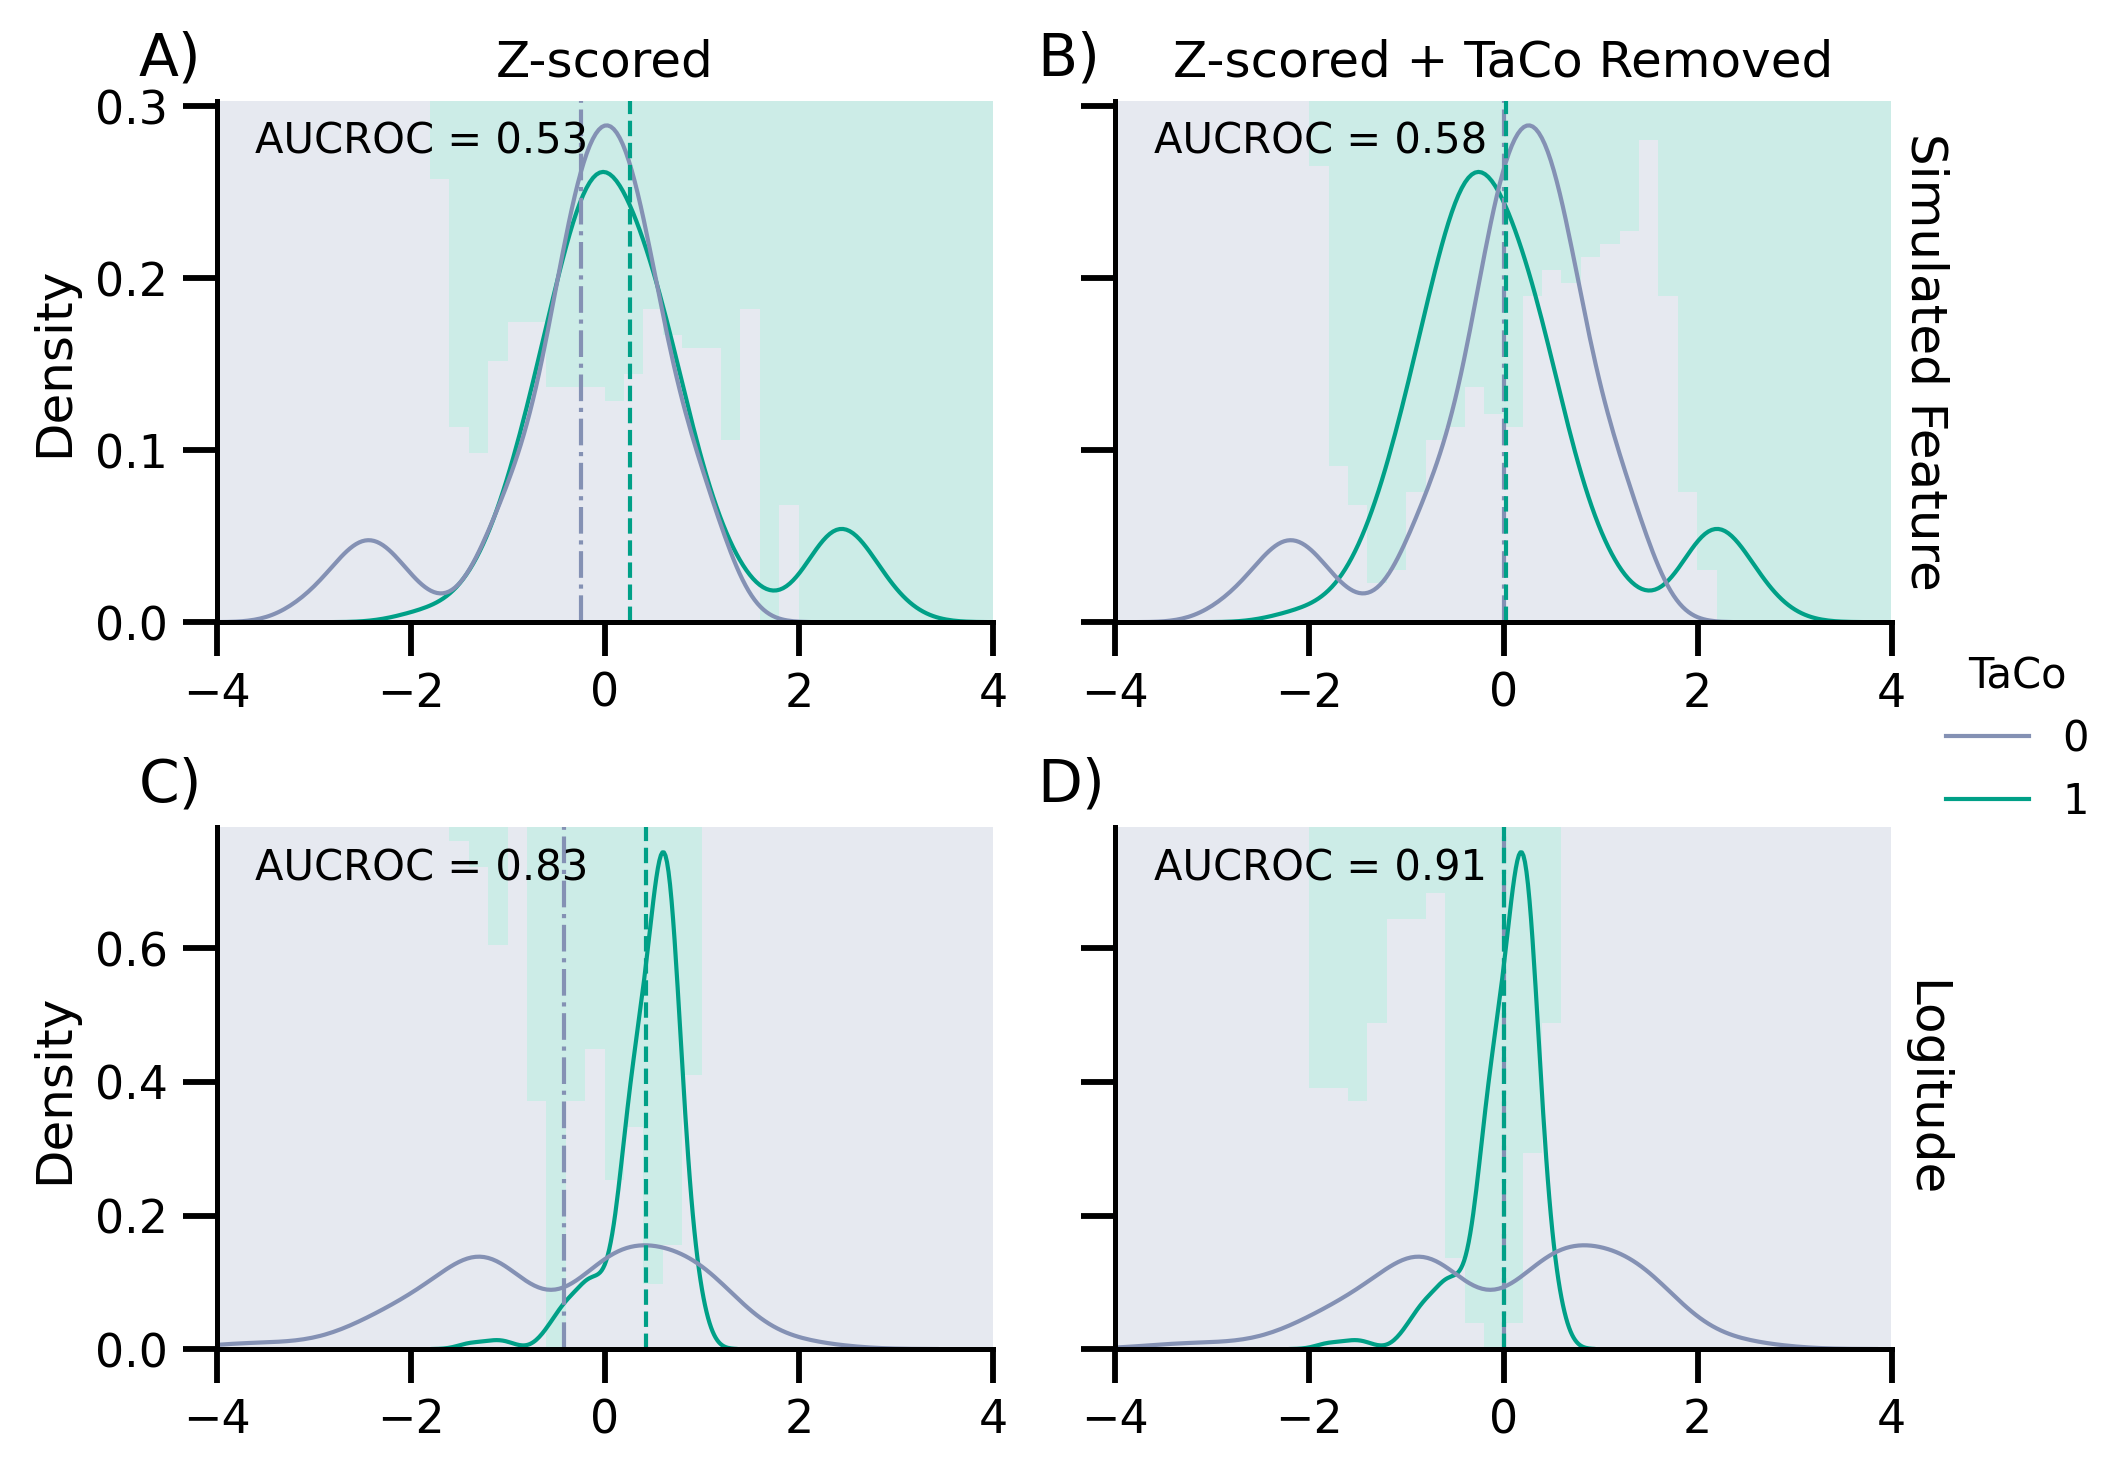

In [18]:
handles = [
    mpl.lines.Line2D([], [], color=purple, label='0'),
    mpl.lines.Line2D([], [], color=green, label='1')
]
fig.legend(handles=handles, title="TaCo", loc=[.91, .43])

for ax, txt in zip(axes.flatten(), ["A)", "B)", "C)", "D)"]):
    ax.text(-.1, 1.05, txt, transform=ax.transAxes, size=14)


fig

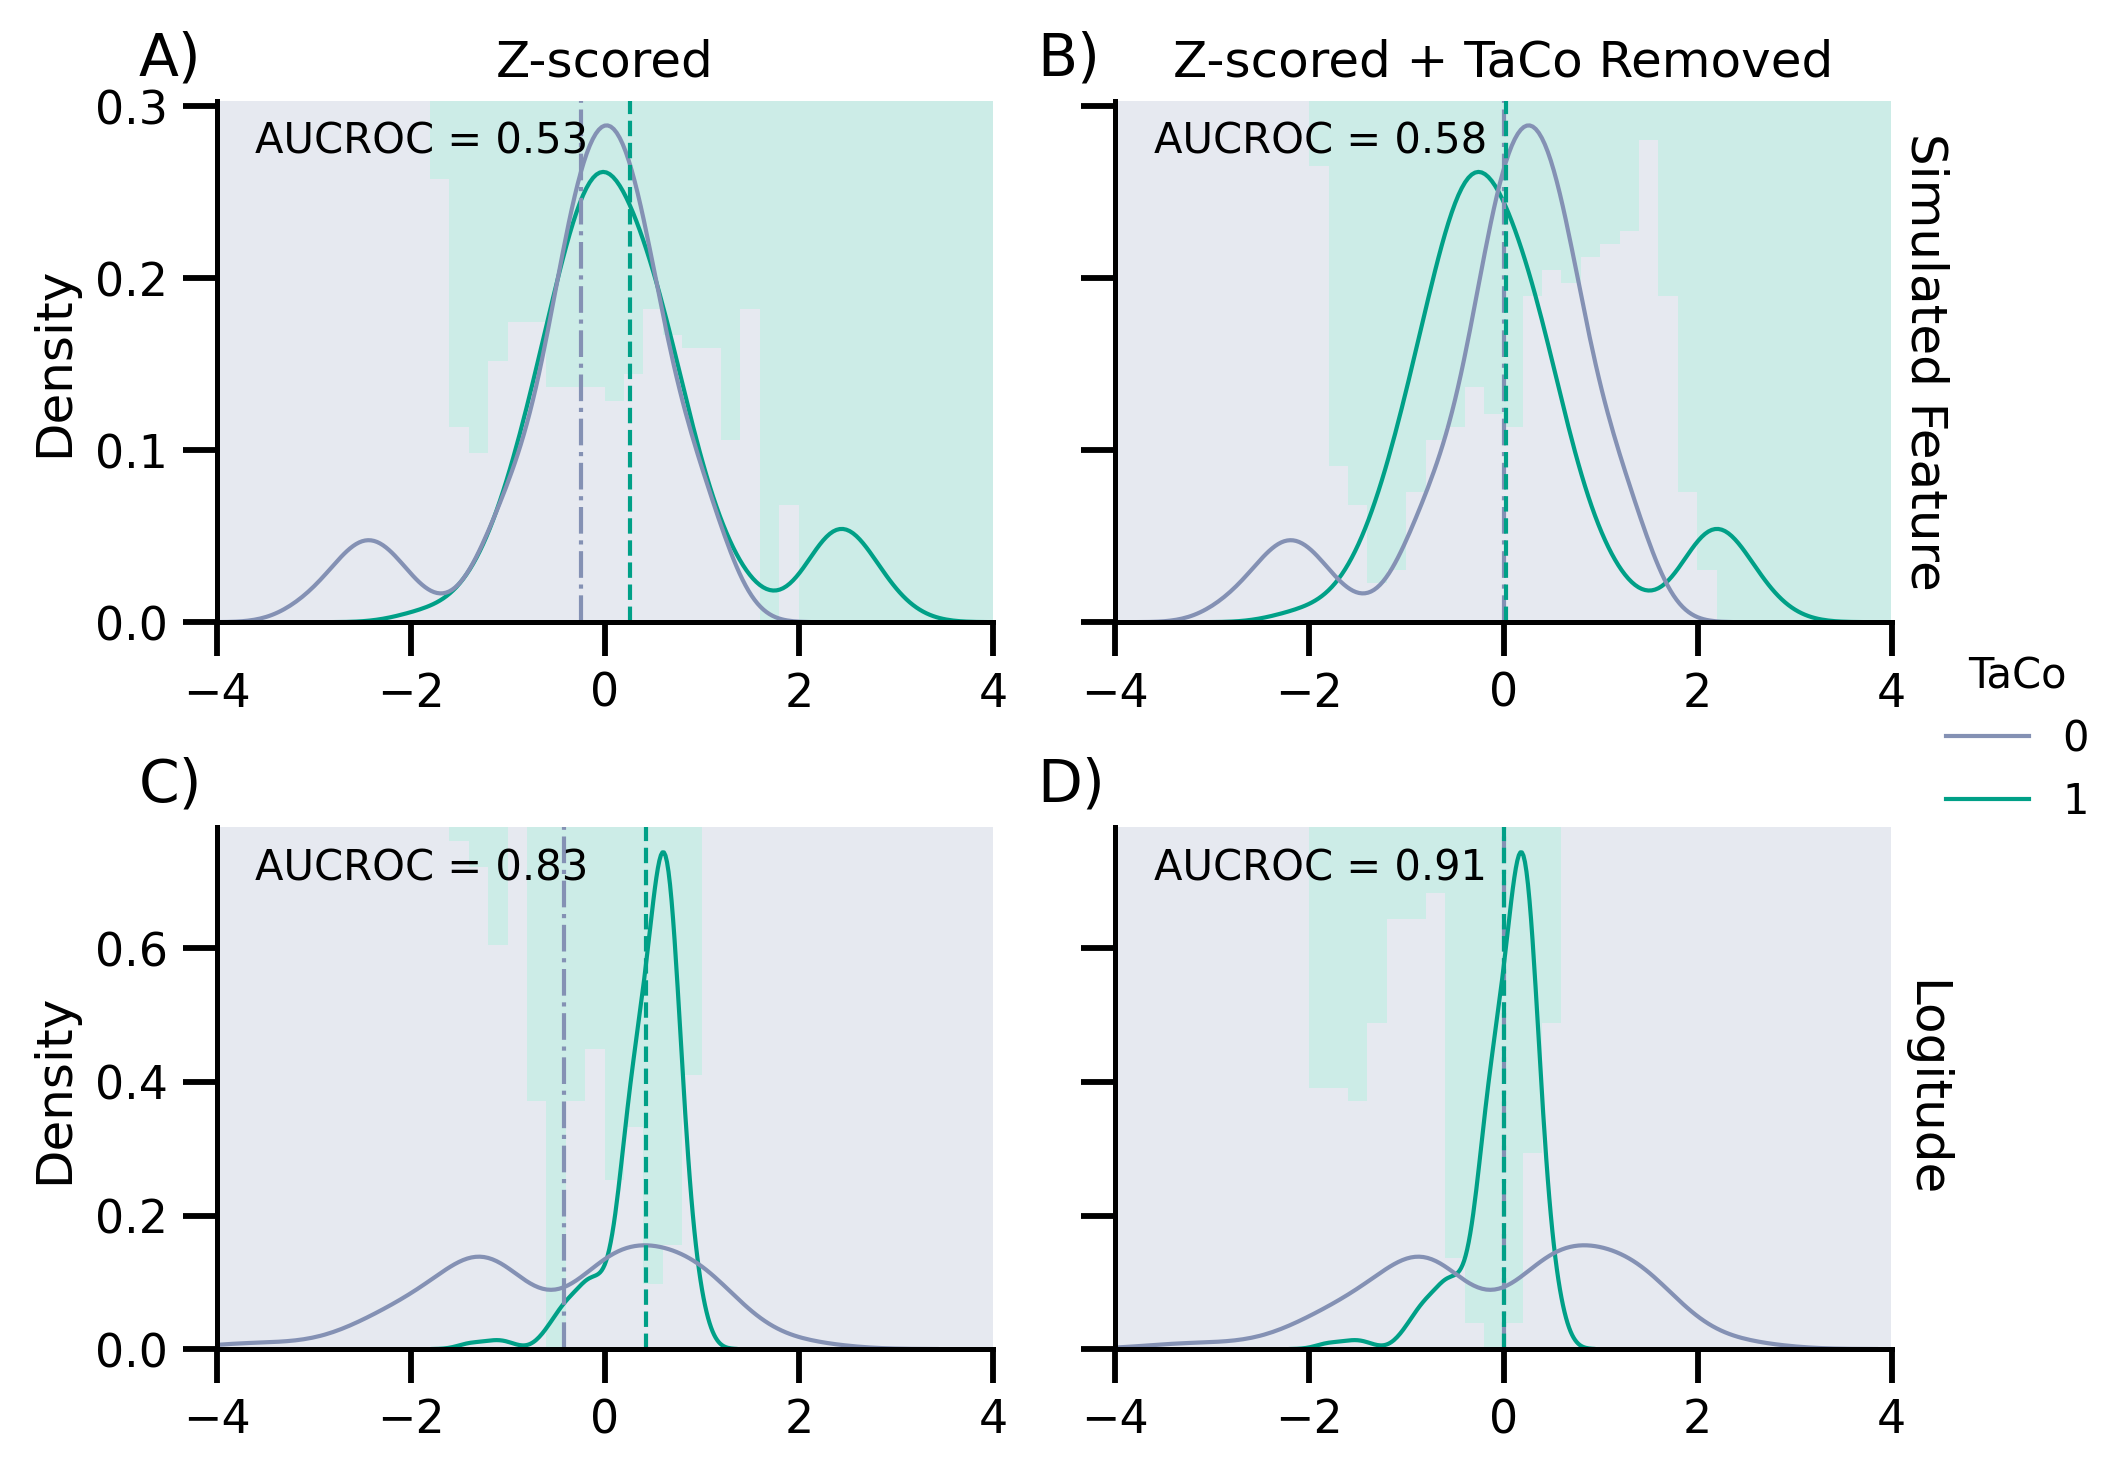

In [19]:
fig.savefig('./saved_figures/03_binary_complete.svg')
fig.savefig('./saved_figures/03_binary_complete.png')
joblib.dump(
    [fig, axes], './saved_figures/03_binary_complete.figure')
fig

## Analysing The Effect of Random Features
Either normal distributed or following chi2

In [20]:
target = np.random.normal(size=500)

df = pd.DataFrame(dict(
    conf=target, target=target))
for i in range(100):
    print(i)
    df[f'feat_{i}'] = skewed_sampler(size=500)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


First using normal distributed random features

In [21]:
all_scores_no_rem = []
all_yerr_no_rem = []
all_scores_rem = []
all_yerr_rem = []

feat_nbr = [1, *list(range(10, 101, 10))]

for i in feat_nbr:
    scores_no_rem = run_cross_validation(
        X=[f'feat_{ii}' for ii in range(i)], y='target', data=df,
        model='rf',
        preprocess_confounds='zscore',
        cv=RepeatedKFold(),
        scoring='r2', problem_type='regression'

    ).test_score
    all_scores_no_rem.append(scores_no_rem.mean())
    all_yerr_no_rem.append(scores_no_rem.std())

    scores_rem = run_cross_validation(
        X=[f'feat_{ii}' for ii in range(i)], y='target', data=df, confounds=['conf'],
        model='rf', preprocess_X=['zscore', 'remove_confound'],
        preprocess_confounds='zscore',
        cv=RepeatedKFold(),
        scoring='r2', problem_type='regression'


    ).test_score

    save_paper_val(increase_features_save_paper,
                   "reasons_continuous_feat", "raw",
                   f"mean_iter_{i}.txt",
                   scores_no_rem.mean())

    save_paper_val(increase_features_save_paper,
                   "reasons_continuous_feat", "raw",
                   f"std_iter_{i}.txt",
                   scores_no_rem.std())

    save_paper_val(increase_features_save_paper,
                   "reasons_continuous_feat", "removed",
                   f"mean_iter_{i}.txt",
                   scores_rem.mean())

    save_paper_val(increase_features_save_paper,
                   "reasons_continuous_feat", "removed",
                   f"std_iter_{i}.txt",
                   scores_rem.std())

    all_scores_rem.append(scores_rem.mean())
    all_yerr_rem.append(scores_rem.std())

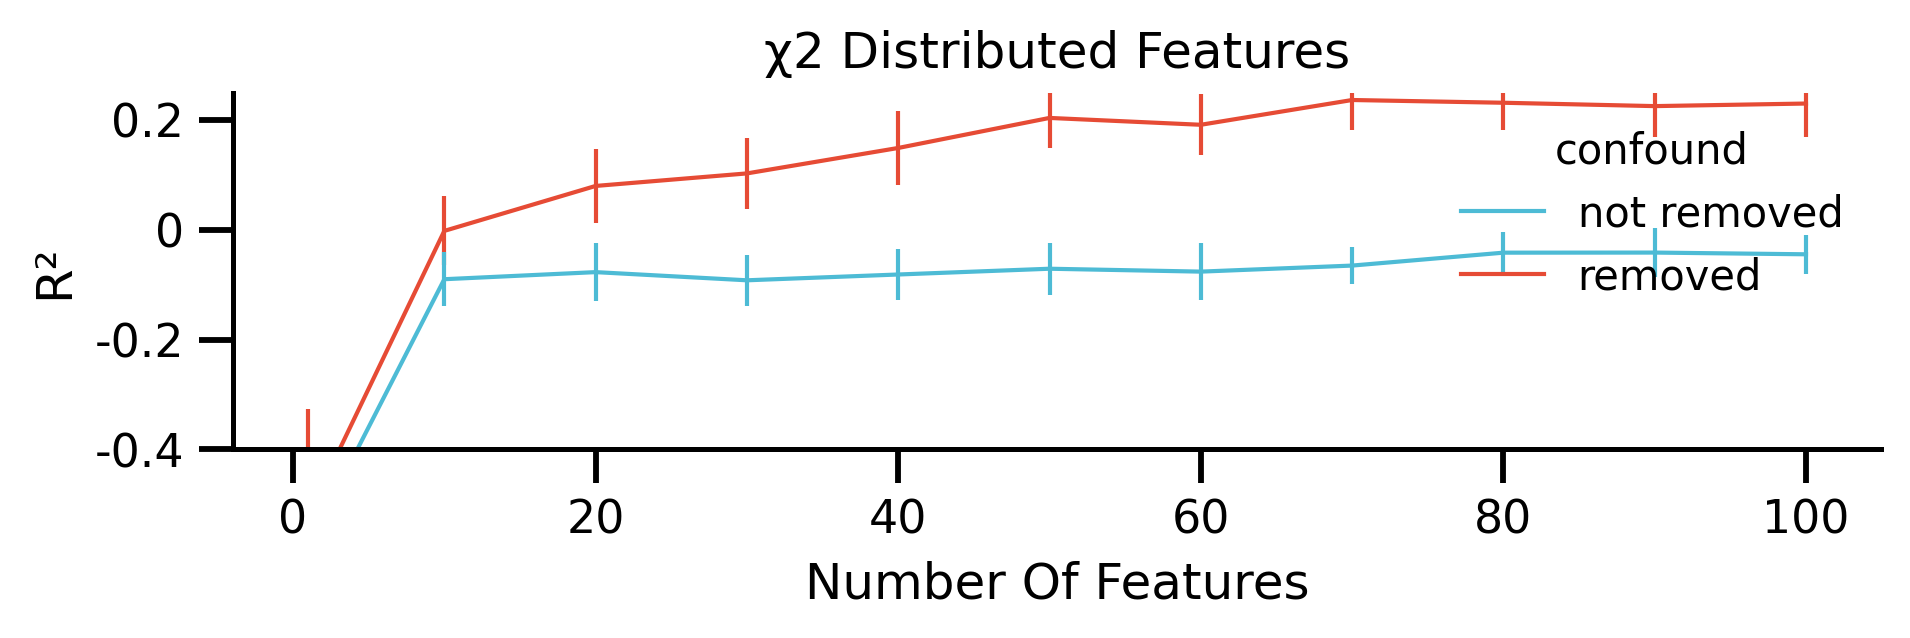

In [22]:
df_rem = pd.DataFrame(dict(scores=all_scores_rem,
                           iteration=feat_nbr,
                           yerr=all_yerr_rem
                           ))
df_rem['remove confounds'] = 'confound removed'
df_no_rem = pd.DataFrame(dict(scores=all_scores_no_rem,
                              iteration=feat_nbr,
                              yerr=all_yerr_no_rem
                              ))
df_no_rem['remove confounds'] = 'no removal'

df_plot = pd.concat([df_rem, df_no_rem])

df_plot['confound'] = df_plot['remove confounds'].apply(
    lambda x: ('removed' if x == 'confound removed' else 'not removed'))

fig, ax = plt.subplots(figsize=[mm_to_inch(180), mm_to_inch(40)])
g = sns.lineplot(x='iteration', y='scores',
                 hue='confound',
                 hue_order=['not removed', 'removed'],
                 data=df_plot.reset_index(),
                 palette=sns.color_palette([blue, red]),
                 ax=ax
                 )

g.set(xlabel='Number Of Features', ylabel='R²',
      title='χ2 Distributed Features')
df_plot_removed = df_plot.query('confound=="removed"')
ax.errorbar(df_plot_removed['iteration'], df_plot_removed['scores'],
            df_plot_removed['yerr'], fmt='none', color=red)

df_plot_not_removed = df_plot.query('confound=="not removed"')
ax.errorbar(df_plot_not_removed['iteration'], df_plot_not_removed['scores'],
            df_plot_not_removed['yerr'], fmt='none', color=blue)

ax.yaxis.set_major_locator(
    mpl.ticker.FixedLocator([-.4, -.2, 0, .2]))

ax.yaxis.set_major_formatter(
    mpl.ticker.FixedFormatter([-.4, -.2, 0, .2]))

ax.set_ylim(-.4, .25)

fig.savefig('./saved_figures/increasing_feat_chi.png')
fig.savefig('./saved_figures/increasing_feat_chi.svg')

Same for not skewed features

In [23]:
# target = np.array([[0, 1]*500]).flatten()
target = np.random.normal(size=500)

df = pd.DataFrame(dict(
    conf=target, target=target))
for i in range(100):
    df[f'feat_{i}'] = np.random.normal(size=500)

In [24]:
all_scores_no_rem = []
all_yerr_no_rem = []
all_scores_rem = []
all_yerr_rem = []

for i in feat_nbr:
    scores_no_rem = run_cross_validation(
        X=[f'feat_{ii}' for ii in range(i)], y='target', data=df,
        model='rf',
        preprocess_confounds='zscore',
        cv=RepeatedKFold(),
        scoring='r2', problem_type='regression'

    ).test_score
    all_scores_no_rem.append(scores_no_rem.mean())
    all_yerr_no_rem.append(scores_no_rem.std())

    scores_rem = run_cross_validation(
        X=[f'feat_{ii}' for ii in range(i)], y='target', data=df, confounds=['conf'],
        model='rf', preprocess_X=['zscore', 'remove_confound'],
        preprocess_confounds='zscore',
        cv=RepeatedKFold(),
        scoring='r2', problem_type='regression'


    ).test_score

    save_paper_val(increase_features_save_paper,
                   "reasons_continuous_feat", "raw",
                   "mean_increasing_features.txt",
                   scores_no_rem.mean())

    save_paper_val(increase_features_save_paper,
                   "reasons_continuous_feat", "raw",
                   "std_increasing_features.txt",
                   scores_no_rem.std())

    save_paper_val(increase_features_save_paper,
                   "reasons_continuous_feat", "removed",
                   "mean_increasing_features.txt",
                   scores_rem.mean())

    save_paper_val(increase_features_save_paper,
                   "reasons_continuous_feat", "removed",
                   "std_increasing_features.txt",
                   scores_rem.std())
    all_scores_rem.append(scores_rem.mean())
    all_yerr_rem.append(scores_rem.std())


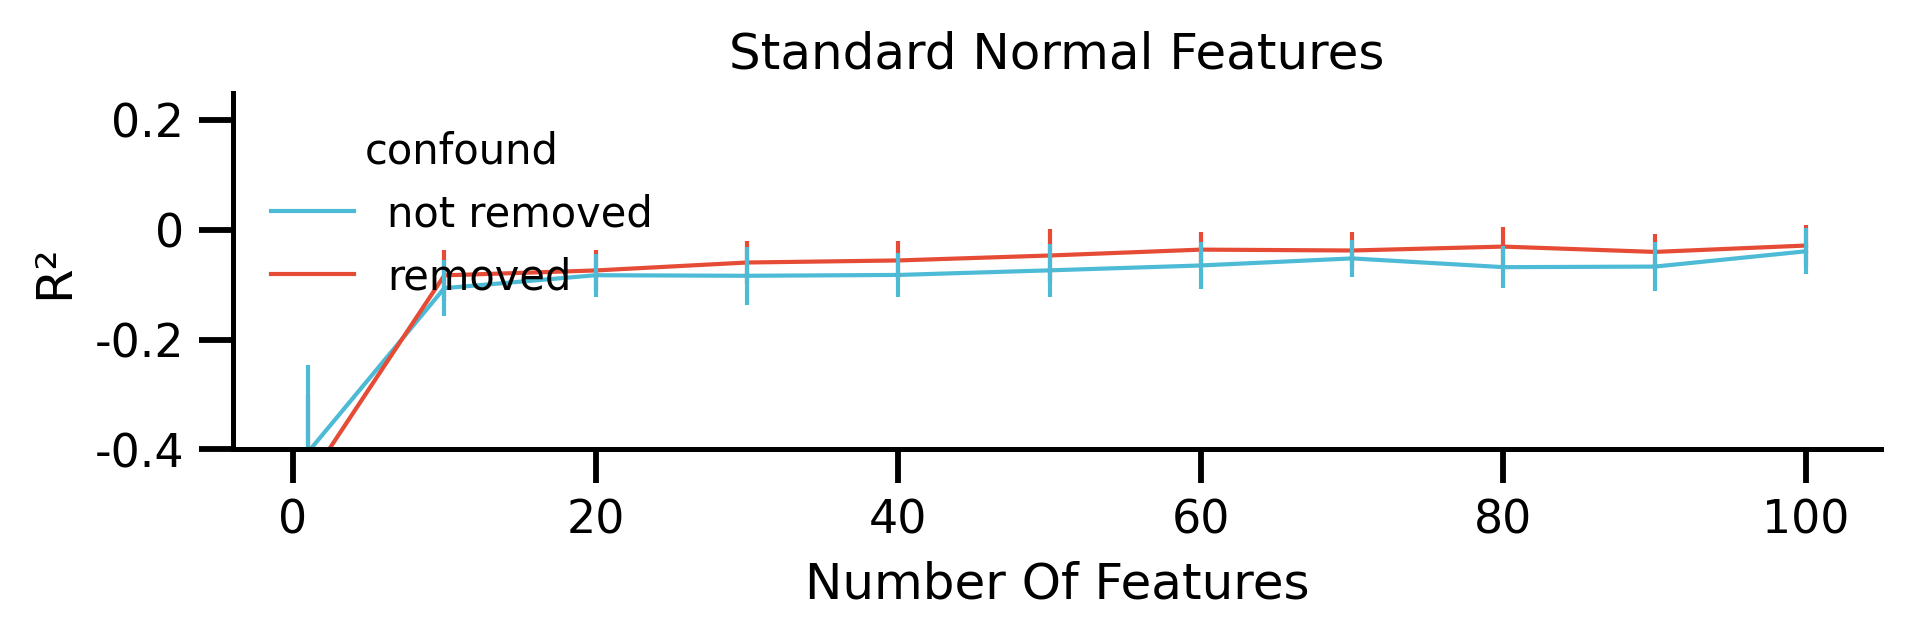

In [25]:
df_rem = pd.DataFrame(dict(scores=all_scores_rem,
                           iteration=feat_nbr,
                           yerr=all_yerr_rem
                           ))
df_rem['remove confounds'] = 'confound removed'
df_no_rem = pd.DataFrame(dict(scores=all_scores_no_rem,
                              iteration=feat_nbr,
                              yerr=all_yerr_no_rem
                              ))
df_no_rem['remove confounds'] = 'no removal'

df_plot = pd.concat([df_rem, df_no_rem])

df_plot['confound'] = df_plot['remove confounds'].apply(
    lambda x: ('removed' if x == 'confound removed' else 'not removed'))
fig, ax = plt.subplots(figsize=[mm_to_inch(180), mm_to_inch(40)])
g = sns.lineplot(x='iteration', y='scores',
                 hue='confound',
                 hue_order=['not removed', 'removed'],
                 data=df_plot.reset_index(),
                 palette=sns.color_palette([blue, red]),
                 ax=ax

                 )
g.set(xlabel='Number Of Features', ylabel='R²',
      title='Standard Normal Features')

df_plot_removed = df_plot.query('confound=="removed"')
ax.errorbar(df_plot_removed['iteration'], df_plot_removed['scores'],
            df_plot_removed['yerr'], fmt='none', color=red)

df_plot_not_removed = df_plot.query('confound=="not removed"')
ax.errorbar(df_plot_not_removed['iteration'], df_plot_not_removed['scores'],
            df_plot_not_removed['yerr'], fmt='none', color=blue)
ax.yaxis.set_major_locator(
    mpl.ticker.FixedLocator([-.4, -.2, 0, .2]))

ax.yaxis.set_major_formatter(
    mpl.ticker.FixedFormatter([-.4, -.2, 0, .2]))

ax.set_ylim(-.4, .25)

fig.savefig('./saved_figures/increasing_feat_normal.png')
fig.savefig('./saved_figures/increasing_feat_normal.svg')